# All the Linear Algebra You Need for AI

The purpose of this notebook is to serve as an explanation of two crucial linear algebra operations used when coding neural networks: matrix multiplication and broadcasting.

## Introduction

**Matrix multiplication** is a way of combining two matrices (involving multiplying and summing their entries in a particular way).  **Broadcasting** refers to how libraries such as Numpy and PyTorch can perform operations on matrices/vectors with mismatched dimensions (in particular cases, with set rules).  We will use broadcasting to show an alternative way of thinking about matrix multiplication from, different from the way it is standardly taught.

In keeping with the [fast.ai teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653), we will:

- first use a pre-defined class for our neural network
- then define the net ourselves to see where it uses matrix multiplication & broadcasting
- and finally dig into the details of how those operations work

This is different from how most math courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

<img src="images/demba_combustion_engine.png" alt="" style="width: 50%"/>
<center>
(source: [Demba Ba](https://github.com/zalandoresearch/fashion-mnist) and [Arvind Nagaraj](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153))
</center>

### More linear algebra resources

This notebook was originally created for a 40 minute talk I gave at the [O'Reilly AI conference in San Francisco](https://conferences.oreilly.com/artificial-intelligence/ai-ca).  If you want further resources for linear algebra, here are a few recommendations:

- [3Blue1Brown Essence of Linear Algebra](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) videos about *geometric intuition*, which are gorgeous and great for visual learners
- [Khan Academy Linear Algebra](https://www.khanacademy.org/math/linear-algebra) videos covering traditional linear algebra material
- [Immersive linear algebra](http://immersivemath.com/ila/) free online textbook with interactive graphics
- [Chapter 2](http://www.deeplearningbook.org/contents/linear_algebra.html) of Ian Goodfellow's Deep Learning Book for a fairly academic take
- [Computational Linear Algebra](http://www.fast.ai/2017/07/17/num-lin-alg/): a free, online fast.ai course, originally taught in the University of San Francisco's Masters in Analytics program. It includes a free [online textbook](https://github.com/fastai/numerical-linear-algebra/blob/master/README.md) and [series of videos](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY). This course is very different from standard linear algebra (which often focuses on how **humans** do matrix calculations), because it is about how to get **computers** to do matrix computations with speed and accuracy, and incorporates modern tools and algorithms.  All the material is taught in Python and centered around solving practical problems such as removing the background from a surveillance video or implementing Google's PageRank search algorithm on Wikipedia pages.

## Our Tools

We will be using the open source [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.  This is the highest level, simplest way to get started with deep learning. Please note that fastai requires Python 3 to function. It is currently in pre-alpha, so items may move around and more documentation will be added in the future.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

### PyTorch

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

### About GPUs

Graphical processing units (GPUs) allow for matrix computations to be done with much greater speed, as long as you have a library such as PyTorch that takes advantage of them.  Advances in GPU technology in the last 10-20 years have been a key part of why neural networks are proving so much more powerful now than they did a few decades ago. 

You may own a computer that has a GPU which can be used.  For the many people that either don't have a GPU (or have a GPU which can't be easily accessed by Python), there are a few differnt options:

- **Don't use a GPU**: For the sake of this tutorial, you don't have to use a GPU, although some computations will be slower.  The only change needed to the code is to remove `.cuda()` wherever it appears.
- **Use crestle, through your browser**: [Crestle](https://www.crestle.com/) is a service that gives you an already set up cloud service with all the popular scientific and deep learning frameworks already pre-installed and configured to run on a GPU in the cloud. It is easily accessed through your browser. New users get 10 hours and 1 GB of storage for free. After this, GPU usage is 34 cents per hour. I recommend this option to those who are new to AWS or new to using the console.
- **Set up an AWS instance through your console**: You can create an AWS instance with a GPU by following the steps in this  [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]  AWS charges 90 cents per hour for this.

## Data

### About The Data

Today we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


### Download

Let's download, unzip, and format the data.

In [2]:
path = '../data/'

In [3]:
import os
os.makedirs(path, exist_ok=True)

In [4]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [5]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [6]:
mean = x.mean()
std = x.std()

In [7]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [8]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [24]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

#### Plots 

In [97]:
x_valid.shape

(10000, 784)

In [25]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

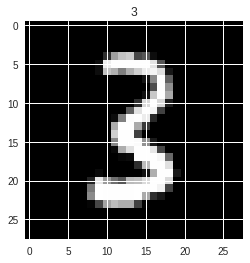

In [99]:
show(x_imgs[0], y_valid[0])

In [117]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [100]:
y_valid[0]

3

We can look at part of an image:

In [26]:
x_imgs[0,10:15,10:15]

array([[-0.4245, -0.4245, -0.4245, -0.4245,  0.1729],
       [-0.4245, -0.4245, -0.4245,  0.7831,  2.4357],
       [-0.4245, -0.272 ,  1.2026,  2.7789,  2.8043],
       [-0.4245,  1.7619,  2.8043,  2.8043,  1.7365],
       [-0.4245,  2.2069,  2.8043,  2.8043,  0.4018]], dtype=float32)

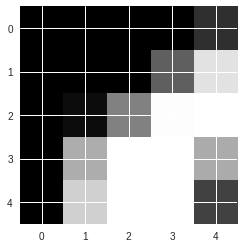

In [29]:
show(x_imgs[0,10:15,10:15])

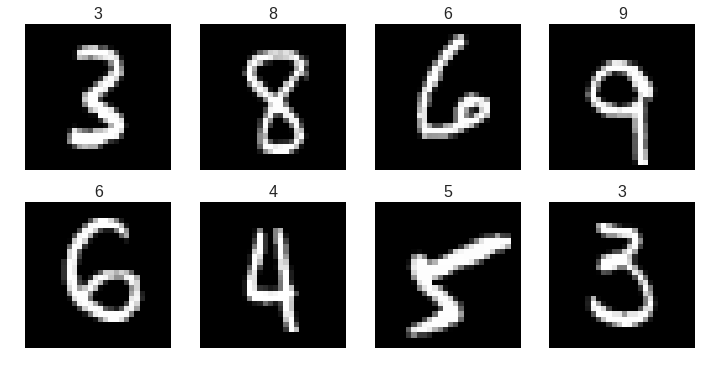

In [101]:
plots(x_imgs[:8], titles=y_valid[:8])

## The Most Important Machine Learning Concepts

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="images/sgd2.gif" alt="" style="width: 70%"/>

In the above gif fast.ai Practical Deep Learning for Coders course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

### Training & Validation data sets

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets.

As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

This is called over-fitting.  A validation set helps prevent this problem.

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**.

## Neural Net (with nn.torch)

### Imports 

In [9]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

###  Neural networks 

We will use fastai's ImageClassifierData, which holds our training and validation sets and will provide batches of that data in a form ready for use by a PyTorch model.

In [10]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [11]:
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.  In our case, we are not interested in viewing the probabilites, and just want to see what the most likely guess is.

### Layers

Sequential defines layers of our network, so let's talk about layers. Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.  Deeper layers are able to capture more complex patterns.

Layer 1 of a convolutional neural network:
<img src="images/zeiler1.png" alt="pytorch" style="width: 40%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Layer 2:
<img src="images/zeiler2.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

Deeper layers can learn about more complicated shapes (although we are only using 2 layers in our network):
<img src="images/zeiler4.png" alt="pytorch" style="width: 90%"/>
<center>
[Matthew Zeiler and Rob Fergus](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf)
</center>

### Training the network 

Next we will set a few inputs for our *fit* method:
- **Optimizer**: algorithm for finding the minimum. typically these are variations on *stochastic gradient descent*, involve taking a step that appears to be the right direction based on the change in the function.
- **Loss**: what function is the optimizer trying to minimize?  We need to say how we're defining the error.
- **Metrics**: other calculations you want printed out as you train

In [12]:
loss=F.cross_entropy
metrics=[accuracy]
opt=optim.Adam(net.parameters())

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [14]:
fit(net, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

[ 0.      0.1446  0.1427  0.9583]                             



GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [36]:
preds = predict(net, md.val_dl)

In [37]:
preds = np.argmax(preds, axis=1)

Let's see how some of our preditions look!

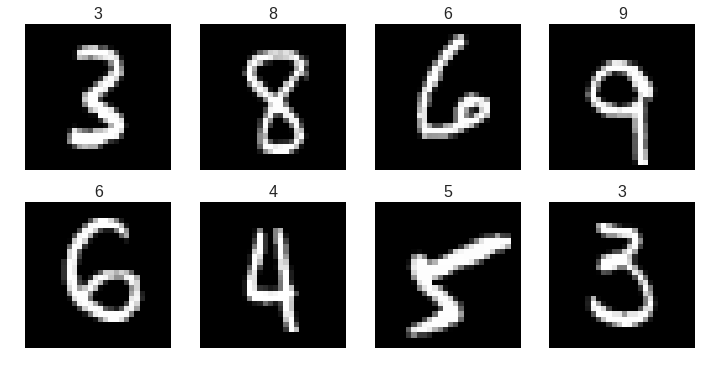

In [38]:
plots(x_imgs[:8], titles=preds[:8])

These predictions are pretty good!

## Coding the Neural Net ourselves

Recall that above we used PyTorch's `Sequential` to define a neural network with a linear layer, a non-linear layer (`ReLU`), and then another linear layer.

In [115]:
# Our code from above
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

It turns out that `Linear` is defined by a matrix multiplication and then an addition.  Let's try defining this ourselves. This will allow us to see exactly where matrix multiplication is used (we will dive in to how matrix multiplication works in the next section).  

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

PyTorch class has two things: constructor (says parameters) and a forward method (how to calculate prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [114]:
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

In [104]:
class SimpleMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 256)  # Layer 1 weights
        self.l1_b = get_weights(256)         # Layer 1 bias
        self.l2_w = get_weights(256, 10)     # Layer 2 weights
        self.l2_b = get_weights(10)          # Layer 2 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b  # Linear Layer
        x = x * (x > 0).float()                     # Non-linear Layer
        x = torch.matmul(x, self.l2_w) + self.l2_b  # Linear Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [102]:
net2 = SimpleMnist().cuda()
opt=optim.Adam(net2.parameters())

In [103]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

[ 0.      0.1635  0.1474  0.9559]



Now we can check our predictions:

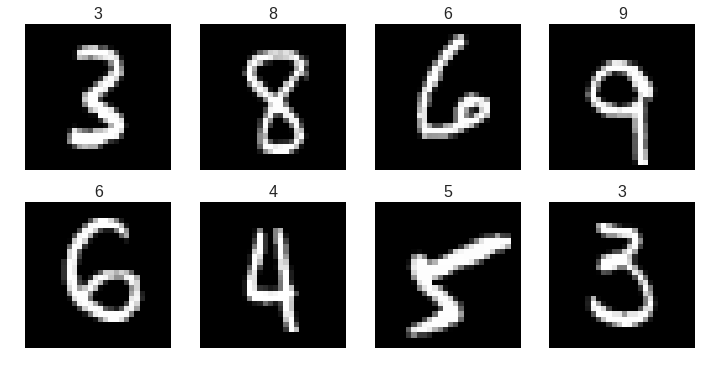

In [90]:
preds = predict(net2, md.val_dl)
preds = np.argmax(preds, axis=1)
plots(x_imgs[:8], titles=preds[:8])

## what torch.matmul (matrix multiplication) is doing

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [44]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

In [45]:
a + b

array([12, 14,  3])

In [46]:
a < b

array([False,  True,  True], dtype=bool)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [105]:
a

array([10,  6, -4])

In [66]:
a > 0

array([ True,  True, False], dtype=bool)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Remember above when we normalized our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar)?  We were using broadcasting!

Other examples of broadcasting with a scalar:

In [67]:
a + 1

array([11,  7, -3])

In [68]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [69]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [70]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [71]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [72]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [91]:
c.shape

(3,)

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [74]:
np.expand_dims(c,0).shape

(1, 3)

In [75]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [76]:
np.expand_dims(c,1).shape

(3, 1)

In [77]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [78]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a $256 \times 256 \times 3$ array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

#### Matrix-Vector Multiplication

In [79]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [93]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

We get the same answer using `torch.matmul`:

In [92]:
torch.matmul(torch.from_numpy(m), torch.from_numpy(c))


 140
 320
 500
[torch.LongTensor of size 3]

The following is **NOT** matrix multiplication.  What is it?

In [67]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [70]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [115]:
c

array([10, 20, 30])

In [114]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**. 

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

Draw a picture

In [113]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [111]:
m @ n

array([[140, 100],
       [320, 280],
       [500, 460]])

In [118]:
(m * n[:,0]).sum(axis=1)

array([140, 320, 500])

In [119]:
(m * n[:,1]).sum(axis=1)

array([ 25, 130, 235])

## Homework: another use of broadcasting

If you want to test your understanding of the above tutorial.  I encourage you to work through it again, only this time use **CIFAR 10**, a dataset that consists of 32x32 *color* images in 10 different categories.  Color images have an extra dimension, containing RGB values, compared to black & white images.

<img src="images/cifar10.png" alt="" style="width: 70%"/>
<center>
(source: [Cifar 10](https://www.cs.toronto.edu/~kriz/cifar.html))
</center>

Fortunately, broadcasting will make it relatively easy to add this extra dimension (for color RGB), but you will have to make some changes to the code.

## Other applications of Matrix and Tensor Products

Here are some other examples of where matrix multiplication arises.  This material is taken from [Chapter 1](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/1.%20Why%20are%20we%20here.ipynb) of my [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course. 

#### Matrix-Vector Products:

The matrix below gives the probabilities of moving from 1 health state to another in 1 year.  If the current health states for a group are:
- 85% asymptomatic
- 10% symptomatic
- 5% AIDS
- 0% death

what will be the % in each health state in 1 year?

<img src="images/markov_health.jpg" alt="floating point" style="width: 80%"/>(Source: [Concepts of Markov Chains](https://www.youtube.com/watch?v=0Il-y_WLTo4))

#### Answer

In [6]:
import numpy as np

In [19]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 0.765 ],
       [ 0.1525],
       [ 0.0645],
       [ 0.018 ]])

#### Matrix-Matrix Products

<img src="images/shop.png" alt="floating point" style="width: 100%"/>(Source: [Several Simple Real-world Applications of Linear Algebra Tools](https://www.mff.cuni.cz/veda/konference/wds/proc/pdf06/WDS06_106_m8_Ulrychova.pdf))

#### Answer

In [23]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 50. ,  49. ],
       [ 58.5,  61. ],
       [ 43.5,  43.5]])

## End

A Tensor is a *multi-dimensional matrix containing elements of a single data type*: a group of data, all with the same type (e.g. A Tensor could store a 4 x 4 x 6 matrix of 32-bit signed integers).